# P11_Data preparation for market research

Our company aims at exporting chicken from France to abroad. For this we need to do a market research to find the best country or countries to export to. For this study, the comapny does not provide any data and we should base our research only on open source ressources.

The first step was to find the data. Below is a list of the different data sources, with the indicators that come from it:

- World Bank: GDP, Index of ease of business, logistics performance index , political stability index, Population, consumer price index.
- FAOSTAT: Chicken consumption, Chicken import value, Chicken import quantity.
- Our World in Data: Share of customer expenditure spent on food, corruption perception index.
- UNSD: Country codes

We decided to take only data from 2021 or before, as the year 2022 and beyond were marked by events which massively changed the global logistics and exports. These changes being still ongoing and changing rapidly, we think that a snapshot of the year 2021 is a good base to start with, this base should be followed by a "state of the art" study based on recent events, but this study is beyond the scope of this project. Most of the indicators are from the year 2021, except the indicators which were not available in 2021, the most recent version of these indicators was used.

## 1_Library and data loading

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display ## Allows to display several clean tables per cell
from scipy.stats import zscore

## To fill NAs
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

In [2]:
## World Bank data
print("World bank data")
wb_df = pd.read_csv("../Data/world_bank_2021.csv")
## Remove country name
wb_df = wb_df.loc[ : , wb_df.columns != 'country']
wb_df.head()

World bank data


,country_code,consumer_price_index,gdp_dollar,ease_business_2019,logistics_performance_2018,political_stability,population
0,ABW,NaN,2.929447e+09,NaN,NaN,1.431727,107700.0
1,AFE,NaN,1.085750e+12,NaN,2.492222,NaN,713090928.0
2,AFG,NaN,1.426000e+10,173.0,1.950000,-2.518676,40000412.0
3,AFW,NaN,8.493120e+11,NaN,2.413333,NaN,485920997.0
4,AGO,583.675779,6.650513e+10,177.0,2.050000,-0.710481,34532429.0


In [3]:
## Corruption index
print("Corruption index")
corruption_df = pd.read_csv("../Data/corruption_index.csv")
## Remove country name
corruption_df = corruption_df.loc[ : , corruption_df.columns != 'country']
corruption_df.head()

Corruption index


,country_code,corruption
0,AFG,16.0
1,ALB,35.0
2,DZA,33.0
3,AGO,29.0
4,ARG,38.0


In [4]:
## Share of customer expenditure on food
print("Share of customer expenditure on food")
expenditure_food_df = pd.read_csv("../Data/share_customer_expenditure_food.csv")

## Remove country name
expenditure_food_df = expenditure_food_df.loc[ : , expenditure_food_df.columns != 'country']

expenditure_food_df.head()

Share of customer expenditure on food


,code,Year,share_food
0,DZA,2018,37.270523
1,DZA,2019,37.413000
2,DZA,2020,37.547940
3,DZA,2021,37.255870
4,DZA,2022,37.130560


In [5]:
## Chicken meat imports
print("Chicken meat imports")
chicken_import_df = pd.read_csv("../Data/chicken_import_export.csv")
chicken_import_df.head()

Chicken meat imports


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,TCL,Crops and livestock products,4,Afghanistan,5610,Import quantity,21121,"Meat of chickens, fresh or chilled",2017,2017,t,28937.00,A,Official figure,NaN
1,TCL,Crops and livestock products,4,Afghanistan,5622,Import value,21121,"Meat of chickens, fresh or chilled",2017,2017,1000 USD,28934.00,A,Official figure,NaN
2,TCL,Crops and livestock products,4,Afghanistan,5910,Export quantity,21121,"Meat of chickens, fresh or chilled",2017,2017,t,36.99,A,Official figure,NaN
3,TCL,Crops and livestock products,4,Afghanistan,5922,Export value,21121,"Meat of chickens, fresh or chilled",2017,2017,1000 USD,31.00,A,Official figure,NaN
4,TCL,Crops and livestock products,4,Afghanistan,5610,Import quantity,21121,"Meat of chickens, fresh or chilled",2018,2018,t,23913.00,A,Official figure,NaN


In [6]:
## Chicken meat consumption
print("Chicken meat consumption")
chicken_consumption_df = pd.read_csv("../Data/chicken_consumption.csv")
chicken_consumption_df.head()

Chicken meat consumption


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,SCL,Supply Utilization Accounts (2010-),4,Afghanistan,5610,Import quantity,21121,"Meat of chickens, fresh or chilled",2017,2017,t,28937.00,A,Official figure,NaN
1,SCL,Supply Utilization Accounts (2010-),4,Afghanistan,5141,Food supply quantity (tonnes),21121,"Meat of chickens, fresh or chilled",2017,2017,t,63514.11,E,Estimated value,NaN
2,SCL,Supply Utilization Accounts (2010-),4,Afghanistan,5610,Import quantity,21121,"Meat of chickens, fresh or chilled",2018,2018,t,23913.00,A,Official figure,NaN
3,SCL,Supply Utilization Accounts (2010-),4,Afghanistan,5141,Food supply quantity (tonnes),21121,"Meat of chickens, fresh or chilled",2018,2018,t,52832.16,E,Estimated value,NaN
4,SCL,Supply Utilization Accounts (2010-),4,Afghanistan,5610,Import quantity,21121,"Meat of chickens, fresh or chilled",2019,2019,t,42875.43,X,Figure from international organizations,Estimated data using trading partners database


In [7]:
## Country code correspondance
print("Country code correspondance")
country_code_df = pd.read_csv("../Data/country_code_correspondance.csv")
country_code_df.head()

Country code correspondance


,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


## 2_Filter and arrange data
We want all the markers in a table similar to the World Bank df: A matrix containing one country per line, and one indicator per column. We want each indicator only for the year 2021 or soon before. Our goal is to end up with a matrix containing only countries (no organizations or regions) with no missing data.

- First of all, we will filter the data to remove any unwanted indicators, and any year we are not interested in.
- Then we will reshape it to have one indicator per column for each data frame.
- Then we will create a new data frame where we will join all the data together on the basis of the country ISO alpha-3 code.
- We will then check the data available and find the possible missing values. The countries with many missing values will be removed from this analysis, the countries with few missing values will be treated per-case, we will try to infer them from either previous year data or by averaging the data from its neighbors.

### Share of customer expenditure on food

In [8]:
## filter year 2021
expenditure_food_2021 = expenditure_food_df.loc[
            expenditure_food_df['Year']==2021,[ 'code', 'share_food']
            ].reset_index(drop = True)

print( "The data frame contains {} countries.".format(expenditure_food_2021.shape[0]) )
expenditure_food_2021.head()


The data frame contains 104 countries.


,code,share_food
0,DZA,37.255870
1,AGO,49.737926
2,ARG,23.198097
3,AUS,9.974969
4,AUT,11.312785


### Chicken import

In [9]:
## Select year 2021
chicken_import_select = chicken_import_df[ (chicken_import_df['Year'] == 2021) & (chicken_import_df['Element'].isin(['Import quantity', 'Import value']) )]

## pivot table to wider form
chicken_import_select = chicken_import_select.pivot(
    index = 'Area Code (M49)',
    columns = 'Element',
    values = 'Value'
).rename(columns = {
    'Import quantity' : 'import_qt',
    'Import value' : 'import_value'
})

chicken_import_select.head()


Element,import_qt,import_value
Area Code (M49),,
4,33025.85,46347.0
8,21929.50,23856.0
12,0.40,1.0
24,240448.80,236981.0
28,5724.56,11483.0


### Chicken consumption

In [10]:
## Select year 2021
chicken_consumption_select = chicken_consumption_df[ (chicken_consumption_df['Year'] == 2021) & (chicken_consumption_df['Element'] == 'Food supply quantity (tonnes)' )]

## pivot table to wider form
chicken_consumption_select = chicken_consumption_select[['Area Code (M49)', 'Value']].reset_index(
    drop = True).rename( columns = {
    'Area Code (M49)' : 'code',
    'Value' : 'chicken_consumption'
    })

chicken_consumption_select.head()

,code,chicken_consumption
0,4,60165.64
1,8,35179.50
2,12,271904.25
3,24,295831.67
4,28,5757.41


## 3_Merge and clean main data frame
### 3.1 Join all the tables

In [11]:
## Create the base merging table
merge_base = country_code_df[['Country or Area', 'M49 Code', 'ISO-alpha2 Code', 'ISO-alpha3 Code']]

## Join the World Bank data
all_data_df = merge_base.join(
    wb_df.set_index('country_code'), 
    how = 'left',
    on = 'ISO-alpha3 Code'
).join(  ## And the share of expenditure on food
    expenditure_food_2021.set_index('code'), 
    how = 'left',
    on = 'ISO-alpha3 Code'
).join( ## And the corruption index
    corruption_df.set_index('country_code'),
    how = 'left',
    on = 'ISO-alpha3 Code'
).join( ## And chicken consumption
    chicken_consumption_select.set_index('code'), 
    how = 'left',
    on = 'M49 Code'
).join( ## And chicken import quantity and data
    chicken_import_select,
    how = 'left',
    on = 'M49 Code'
).rename(columns = {
    'M49 Code' : 'M49',
    'ISO-alpha2 Code' : 'ISO2',
    'ISO-alpha3 Code' : 'ISO3',
    'Country or Area' : 'country'    
})

print(all_data_df.shape)
print(all_data_df['import_value'].isna().sum())
all_data_df.head()

(248, 15)
60


,country,M49,ISO2,ISO3,consumer_price_index,gdp_dollar,ease_business_2019,logistics_performance_2018,political_stability,population,share_food,corruption,chicken_consumption,import_qt,import_value
0,Algeria,12,DZ,DZA,166.218895,1.862310e+11,157.0,2.45,-0.992457,44761099.0,37.255870,33.0,271904.25,0.40,1.0
1,Egypt,818,EG,EGY,318.936481,4.246720e+11,114.0,2.82,-1.032864,110957008.0,37.588936,33.0,2425360.74,25589.72,94639.0
2,Libya,434,LY,LBY,260.082820,3.521800e+10,186.0,2.11,-2.308474,7135175.0,NaN,17.0,260741.76,129707.09,220964.0
3,Morocco,504,MA,MAR,113.419775,1.420220e+11,53.0,2.54,-0.402563,36954442.0,33.925957,39.0,529565.19,4575.66,2985.0
4,Sudan,729,SD,SDN,16245.888970,3.422951e+10,171.0,2.43,-1.987674,48066924.0,NaN,20.0,80000.00,1348.25,2388.0


### 3.2 Assess missing values

In [12]:
## Get the number of NAs per line
na_count = all_data_df.isna().sum(axis = 1)

## Create frequency table
na_count.value_counts()

0     93
1     51
11    31
2     23
3     15
8     11
9      8
4      4
6      4
7      3
5      3
10     2
Name: count, dtype: int64

Some lines have a many missing values. At this stage we have 10 variables, we will not take any column with more than 20% of the variables missing.
Before removing the lines with more than 2 variables missing, we will check if one variable is particularly absent.

In [13]:
## Get the countries with one missing value
miss_1 = all_data_df

## Get the NA sum per variable
var_na = miss_1.isna().sum(axis = 0)
var_na

country                         0
M49                             0
ISO2                            1
ISO3                            0
consumer_price_index           75
gdp_dollar                     41
ease_business_2019             60
logistics_performance_2018     89
political_stability            44
population                     33
share_food                    145
corruption                     70
chicken_consumption            61
import_qt                      60
import_value                   60
dtype: int64

The share of consumer expenditure on food is by very far the most problematic variable. We will drop it and see what it does to the overall number of missing values.

In [14]:
## Remove share_food column
all_data_df = all_data_df.loc[ : ,all_data_df.columns != 'share_food' ]

## Create new row NA counts
na_count = all_data_df.isna().sum(axis = 1)

print("\nNumber of missing values without share_food variable:")
display( na_count.value_counts() )

## Remove the rows with more than 2 missing values
all_data_df = all_data_df[na_count < 3]

print("\n\nDimensions of the data frame")
print( all_data_df.shape )
print("\n\n")
all_data_df.head()


Number of missing values without share_food variable:


0     139
10     31
1      24
2      18
7      11
8       8
3       5
5       4
6       3
4       3
9       2
Name: count, dtype: int64



Dimensions of the data frame
(181, 14)





,country,M49,ISO2,ISO3,consumer_price_index,gdp_dollar,ease_business_2019,logistics_performance_2018,political_stability,population,corruption,chicken_consumption,import_qt,import_value
0,Algeria,12,DZ,DZA,166.218895,1.862310e+11,157.0,2.45,-0.992457,44761099.0,33.0,271904.25,0.40,1.0
1,Egypt,818,EG,EGY,318.936481,4.246720e+11,114.0,2.82,-1.032864,110957008.0,33.0,2425360.74,25589.72,94639.0
2,Libya,434,LY,LBY,260.082820,3.521800e+10,186.0,2.11,-2.308474,7135175.0,17.0,260741.76,129707.09,220964.0
3,Morocco,504,MA,MAR,113.419775,1.420220e+11,53.0,2.54,-0.402563,36954442.0,39.0,529565.19,4575.66,2985.0
4,Sudan,729,SD,SDN,16245.888970,3.422951e+10,171.0,2.43,-1.987674,48066924.0,20.0,80000.00,1348.25,2388.0


In [15]:
## Impact of the column and row cleaning on global NA values
all_data_df.isna().sum(axis = 0)

country                        0
M49                            0
ISO2                           1
ISO3                           0
consumer_price_index          12
gdp_dollar                     3
ease_business_2019             1
logistics_performance_2018    25
political_stability            0
population                     0
corruption                     7
chicken_consumption            3
import_qt                      4
import_value                   4
dtype: int64

### 3.3 Fill missing values

In [16]:
## Create empty vector to store accuracy values
accuracy_values = {}

## Subset continuous variables
var_subset = all_data_df.iloc[:, 4:]

## Get columns with missing values 
missing_columns = var_subset.columns[var_subset.isnull().any()]

## Loop through missing columns for predictions
for column in missing_columns:
    
    # Get known data
    known = var_subset[ var_subset[ column ].notnull() ]
    
    ## Prepare the data for training and prediction
    X = known.drop(columns = [column])
    y = known[column]

    ## Replace NAs with outlier value
    X.fillna(-9999, inplace = True)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                      test_size = 0.2, random_state = 68)

    # Train the Random Forest Regressor
    rf = RandomForestRegressor( random_state = 68 )
    rf.fit( X_train, y_train )
    
    ## Predict value on the training set
    y_pred_train = rf.predict( X_train )
    y_pred_val = rf.predict( X_val )
    
    ## Calculate accuracy with Mean Relative Error
    mre_train = ((y_pred_train - y_train) / y_train).sum()/len(y_train)
    mre_val = ((y_pred_val - y_val) / y_val).sum()/len(y_val)
    
    accuracy_values[column] = [format( mre_train, '.2f'),                               
                               format( mre_val, '.2f'),
                               format( np.std( var_subset[column] ), ".2e"),
                               format( np.nanquantile( var_subset[column], 0.5), ".2e"),
                               format( np.nanquantile( var_subset[column], 0.75), ".2e"),
                               format( np.mean( var_subset[column]), ".2e")
                              ]

## Return accuracy for each column
print("Estimation of the accuracy of prediction for each variable using the Mean Relative Error:\n")

accuracy_val_tabs = pd.DataFrame(accuracy_values, 
                                 index = ["mre_train", "mre_val", "sd", "median", "Q3", "mean"]).T
accuracy_val_tabs

Estimation of the accuracy of prediction for each variable using the Mean Relative Error:



,mre_train,mre_val,sd,median,Q3,mean
consumer_price_index,0.60,0.77,2.15e+03,1.32e+02,1.81e+02,4.32e+02
gdp_dollar,0.26,0.57,2.29e+12,4.07e+10,2.93e+11,5.41e+11
ease_business_2019,0.19,0.52,5.47e+01,9.45e+01,1.40e+02,9.44e+01
logistics_performance_2018,0.00,-0.01,5.62e-01,2.71e+00,3.22e+00,2.87e+00
corruption,0.02,0.04,1.87e+01,3.90e+01,5.50e+01,4.35e+01
chicken_consumption,0.55,1.69,1.91e+06,1.01e+05,3.41e+05,6.33e+05
import_qt,1.02,0.44,1.77e+05,1.57e+04,6.93e+04,7.82e+04
import_value,21.59,0.14,3.49e+05,2.50e+04,1.20e+05,1.36e+05


In [17]:
## Subset continuous variables
var_subset = all_data_df.iloc[:, 4:]

## Take only data with no missing values
na_count = var_subset.isna().sum(axis = 1)
full_data = var_subset[na_count == 0]

## Get columns with missing values 
missing_columns = var_subset.columns[var_subset.isnull().any()]

## Loop through missing columns for predictions
for column in missing_columns:

    # Separate the data into known and unknown parts
    known = var_subset[ var_subset[ column ].notnull() ]
    unknown = var_subset[ var_subset[ column ].isnull() ]

    ## Prepare the data for training and prediction
    X = known.drop(columns = [column])
    y = known[column]
    X_test = unknown.drop(columns=[column])

    ## Replace NAs with outlier value
    X.fillna(-9999, inplace = True)
    X_test.fillna(-9999, inplace = True)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                      test_size = 0.2, random_state = 68)

    # Train the Random Forest Regressor
    rf = RandomForestRegressor( random_state = 68 )
    rf.fit( X_train, y_train )
    
    ## Predict value on the training set
    y_pred = rf.predict( X_test )

    # Fill the missing values in the original DataFrame
    var_subset.loc[ var_subset[column].isnull(), column] = y_pred

## Check if there are NAs left
var_subset.isna().any()

consumer_price_index          False
gdp_dollar                    False
ease_business_2019            False
logistics_performance_2018    False
political_stability           False
population                    False
corruption                    False
chicken_consumption           False
import_qt                     False
import_value                  False
dtype: bool

There is no NA left, we will replace the original data with the new one.

In [18]:
all_data_df.iloc[:, 4:] = var_subset

display( all_data_df.head() )
print( "\nIn the end, we have {} countries.".format(all_data_df.shape[0]))

,country,M49,ISO2,ISO3,consumer_price_index,gdp_dollar,ease_business_2019,logistics_performance_2018,political_stability,population,corruption,chicken_consumption,import_qt,import_value
0,Algeria,12,DZ,DZA,166.218895,1.862310e+11,157.0,2.45,-0.992457,44761099.0,33.0,271904.25,0.40,1.0
1,Egypt,818,EG,EGY,318.936481,4.246720e+11,114.0,2.82,-1.032864,110957008.0,33.0,2425360.74,25589.72,94639.0
2,Libya,434,LY,LBY,260.082820,3.521800e+10,186.0,2.11,-2.308474,7135175.0,17.0,260741.76,129707.09,220964.0
3,Morocco,504,MA,MAR,113.419775,1.420220e+11,53.0,2.54,-0.402563,36954442.0,39.0,529565.19,4575.66,2985.0
4,Sudan,729,SD,SDN,16245.888970,3.422951e+10,171.0,2.43,-1.987674,48066924.0,20.0,80000.00,1348.25,2388.0



In the end, we have 181 countries.


### 3.4 Calculate new variables
Some of these values are not directly interesting to assess the chicken market. We will create new values out of them to help the machine learning process.

The new variables will be:

- **GDP per capita** (USD per capita) = GDP / population
- **Chicken consumed per capita** (kg per capita) = chicken consumption * 1000 / population
- **Chicken import price per ton** (USD per kg) = chicken import quantity / chicken import value

In [19]:
## Create GDP_per_capita
all_data_df['GDP_capita'] = round( (all_data_df['gdp_dollar'] / all_data_df['population']),
                                  2)

## Chicken consumed per capita
all_data_df['chicken_capita'] = round((all_data_df['chicken_consumption'] * 1000 / all_data_df['population']),
                                      3)

## Chicken import price
all_data_df['import_price'] = round( (all_data_df['import_value'] / all_data_df['import_qt']), 
                                    2)

all_data_df.head()

,country,M49,ISO2,ISO3,consumer_price_index,gdp_dollar,ease_business_2019,logistics_performance_2018,political_stability,population,corruption,chicken_consumption,import_qt,import_value,GDP_capita,chicken_capita,import_price
0,Algeria,12,DZ,DZA,166.218895,1.862310e+11,157.0,2.45,-0.992457,44761099.0,33.0,271904.25,0.40,1.0,4160.55,6.075,2.50
1,Egypt,818,EG,EGY,318.936481,4.246720e+11,114.0,2.82,-1.032864,110957008.0,33.0,2425360.74,25589.72,94639.0,3827.36,21.859,3.70
2,Libya,434,LY,LBY,260.082820,3.521800e+10,186.0,2.11,-2.308474,7135175.0,17.0,260741.76,129707.09,220964.0,4935.83,36.543,1.70
3,Morocco,504,MA,MAR,113.419775,1.420220e+11,53.0,2.54,-0.402563,36954442.0,39.0,529565.19,4575.66,2985.0,3843.16,14.330,0.65
4,Sudan,729,SD,SDN,16245.888970,3.422951e+10,171.0,2.43,-1.987674,48066924.0,20.0,80000.00,1348.25,2388.0,712.12,1.664,1.77


## 4_Description of the variables
In this part, we will have an overall look at our variables of interest. For each variable, we will make a boxplot, which will include the mean and the position of France in the data. Then we will have a look at the outliers as well as the top 10 and bottom 10 countries.

This information is explorative and self explanatory so we will not comment each one.

In [20]:
## Define custom functions
### Calculate descriptive statistics
def calculate_stats(df, col_name):
    ## Get the index of the France row
    index_france = df.loc[df['country'] == 'France'].index.item()
    
    ## Get descriptive statistics
    description = df[col_name].describe()
    
    ## Select the stats we want
    description = description [['mean', 'min', 'max', '25%', '50%', '75%']]
    
    ## Add value for France
    description['France'] = df.at[index_france, col_name]
    
    ## Turn to df
    description = pd.DataFrame(description)
    return description


### Create boxplot
def create_boxplot(df, col_name, description, log):
    
    # Create the boxplot
    sns.boxplot(y=df[col_name], color = 'white')
    if log == True: plt.yscale('log')
    
    # Retrieve the values for annotations
    min_val = description.at['min', col_name]
    q1_val = description.at['25%', col_name]
    median_val = description.at['50%', col_name]
    mean_val = description.at['mean', col_name]
    q3_val = description.at['75%', col_name]
    max_val = description.at['max', col_name]
    france_val = description.at['France', col_name]

    # Add annotations
    plt.scatter(x=0, y=mean_val, 
                color='forestgreen', label='Mean')
    plt.scatter(x=0, y=france_val, 
                color='mediumblue', label='France')

    # Add labels
    plt.text(0, min_val, f'Min: {min_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='right', 
             color='green', fontsize=12)
    plt.text(0, q1_val, f'Q1: {q1_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='right', 
             color='green', fontsize=12)
    plt.text(0, median_val, f'Median: {median_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='right', 
             color='green', fontsize=12)
    plt.text(0, mean_val, f'Mean: {mean_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='left', 
             color='darkgreen', fontsize=12)
    plt.text(0, q3_val, f'Q3: {q3_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='right', 
             color='green', fontsize=12)
    plt.text(0, max_val, f'Max: {max_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='right', 
             color='green', fontsize=12)
    plt.text(0, france_val, f'France: {france_val:.2e}', 
             verticalalignment='bottom', horizontalalignment='left', 
             color='mediumblue', fontsize=12)
    
    # Show the plot
    plt.title(f'Boxplot with Annotations for {col_name}')
    plt.show()

def list_outliers(df, col_name):
    # Calculate interquartile range
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = df[col_name].quantile(0.75) - df[col_name].quantile(0.25)

    # Define the outlier cutoff
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to get the outliers
    outliers = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)]

    # Create a new DataFrame with the country name as the index and the outlier value as a column
    outliers_df = outliers[['country', col_name]].sort_values(col_name, ascending = False)

    return outliers_df

def list_top_flop(df, col_name):
    bottom10 = df.sort_values(
        col_name, ascending = True)[['country', col_name]].head( 10 )
    top10 = df.sort_values(
        col_name, ascending = False)[['country', col_name]].head( 10 )

    return top10, bottom10
    

def complete_desc(df, col_name, log = False):

    # Check if the df is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Error: The first argument is not a valid pandas DataFrame.")

            # Check if the df is a DataFrame
    if not isinstance(df[col_name], pd.Series):
        raise ValueError("Error: The column does not exist in the DataFrame.")

    # Check if the second argument is a boolean
    if not isinstance(log, bool):
        raise ValueError("Error: The third argument must be a boolean.")

    ## Start the description
    description = calculate_stats(df, col_name)
    boxplot = create_boxplot(df, col_name, description, log)
    top10, bottom10 = list_top_flop(df, col_name)
    outlier_list = list_outliers(df, col_name)

    ## Show results
    print("\n\n Highest 10")
    display(top10)

    print("\n\n Lowest 10")
    display(bottom10)
    
    print( "\n\n Outliers:")
    display(outlier_list)


### GDP in dollars

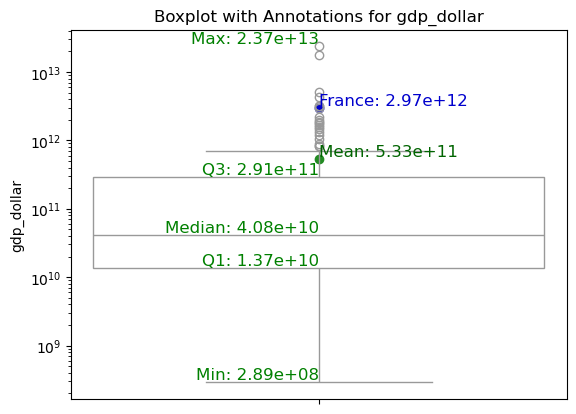



 Highest 10


,country,gdp_dollar
116,United States of America,2.368120e+13
123,China,1.782050e+13
127,Japan,5.034620e+12
213,Germany,4.348300e+12
144,India,3.167270e+12
193,United Kingdom of Great Britain and Northern I...,3.143320e+12
212,France,2.966430e+12
201,Italy,2.179210e+12
113,Canada,2.007470e+12
175,Russian Federation,1.843390e+12




 Lowest 10


,country,gdp_dollar
231,Kiribati,2.893393e+08
245,Tonga,5.182280e+08
37,Sao Tome and Principe,5.244025e+08
70,Dominica,5.552667e+08
243,Samoa,8.439236e+08
80,Saint Kitts and Nevis,8.586222e+08
83,Saint Vincent and the Grenadines,8.722259e+08
229,Vanuatu,9.503940e+08
72,Grenada,1.122800e+09
9,Comoros,1.296089e+09




 Outliers:


,country,gdp_dollar
116,United States of America,2.368120e+13
123,China,1.782050e+13
127,Japan,5.034620e+12
213,Germany,4.348300e+12
144,India,3.167270e+12
193,United Kingdom of Great Britain and Northern I...,3.143320e+12
212,France,2.966430e+12
201,Italy,2.179210e+12
113,Canada,2.007470e+12
175,Russian Federation,1.843390e+12


In [21]:
complete_desc(all_data_df, 'gdp_dollar', True)

### GDP per capita

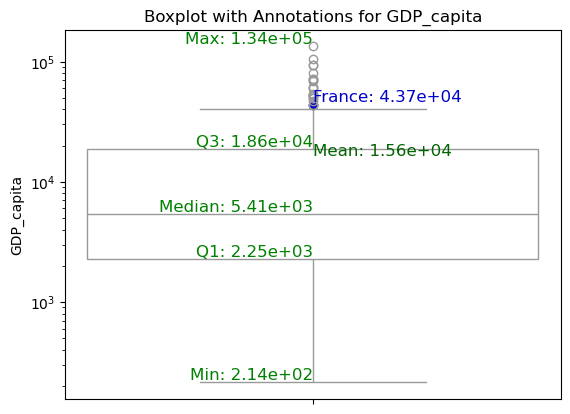



 Highest 10


,country,GDP_capita
215,Luxembourg,133711.79
185,Ireland,105561.23
218,Switzerland,93446.46
190,Norway,93072.90
137,Singapore,79601.49
161,Qatar,71751.88
116,United States of America,71318.39
179,Denmark,69727.95
184,Iceland,69325.91
192,Sweden,61174.98




 Lowest 10


,country,GDP_capita
8,Burundi,214.09
141,Afghanistan,356.50
15,Madagascar,490.21
31,Central African Republic,492.26
19,Mozambique,509.91
23,Somalia,549.11
34,Democratic Republic of the Congo,558.03
54,Niger,608.72
16,Malawi,617.45
32,Chad,660.75




 Outliers:


,country,GDP_capita
215,Luxembourg,133711.79
185,Ireland,105561.23
218,Switzerland,93446.46
190,Norway,93072.90
137,Singapore,79601.49
161,Qatar,71751.88
116,United States of America,71318.39
179,Denmark,69727.95
184,Iceland,69325.91
192,Sweden,61174.98


In [22]:
complete_desc(all_data_df, 'GDP_capita', True)

### Consumer price index

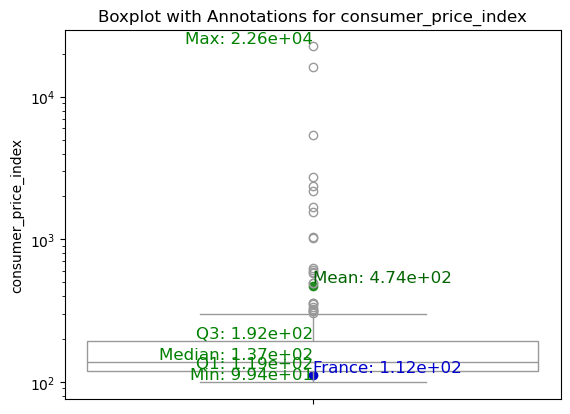



 Highest 10


,country,consumer_price_index
24,South Sudan,22570.711030
4,Sudan,16245.888970
28,Zimbabwe,5411.002445
141,Afghanistan,2717.349474
167,Yemen,2354.896532
164,Syrian Arab Republic,2171.744915
34,Democratic Republic of the Congo,1692.818296
23,Somalia,1553.962709
145,Iran (Islamic Republic of),1031.657502
111,Venezuela (Bolivarian Republic of),1023.312380




 Lowest 10


,country,consumer_price_index
218,Switzerland,99.399284
199,Greece,101.909214
130,Brunei Darussalam,102.698105
80,Saint Kitts and Nevis,104.235929
153,Cyprus,104.348040
127,Japan,105.211812
231,Kiribati,105.218807
196,Bosnia and Herzegovina,105.850178
70,Dominica,106.218257
72,Grenada,108.576481




 Outliers:


,country,consumer_price_index
24,South Sudan,22570.711030
4,Sudan,16245.888970
28,Zimbabwe,5411.002445
141,Afghanistan,2717.349474
167,Yemen,2354.896532
164,Syrian Arab Republic,2171.744915
34,Democratic Republic of the Congo,1692.818296
23,Somalia,1553.962709
145,Iran (Islamic Republic of),1031.657502
111,Venezuela (Bolivarian Republic of),1023.312380


In [23]:
complete_desc(all_data_df, 'consumer_price_index', True)

### Ease of business (2019)

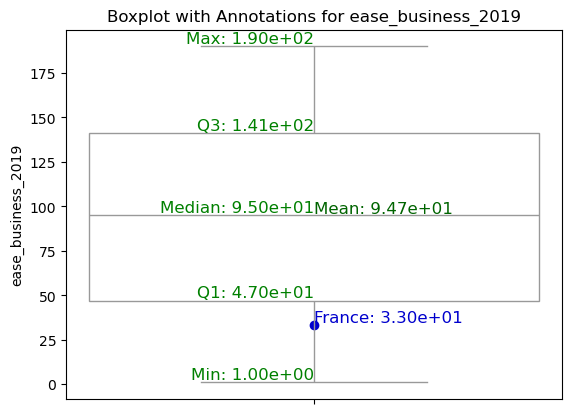



 Highest 10


,country,ease_business_2019
23,Somalia,190.0
111,Venezuela (Bolivarian Republic of),188.0
167,Yemen,187.0
2,Libya,186.0
24,South Sudan,185.0
31,Central African Republic,184.0
34,Democratic Republic of the Congo,183.0
32,Chad,182.0
139,Timor-Leste,181.0
33,Congo,180.0




 Lowest 10


,country,ease_business_2019
223,New Zealand,1.0
137,Singapore,2.0
124,China Hong Kong Special Administrative Region,3.0
179,Denmark,4.0
129,Republic of Korea,5.0
116,United States of America,6.0
154,Georgia,7.0
193,United Kingdom of Great Britain and Northern I...,8.0
190,Norway,9.0
192,Sweden,10.0




 Outliers:


,country,ease_business_2019


In [24]:
complete_desc(all_data_df, 'ease_business_2019')

### Logistics performance index (2018)

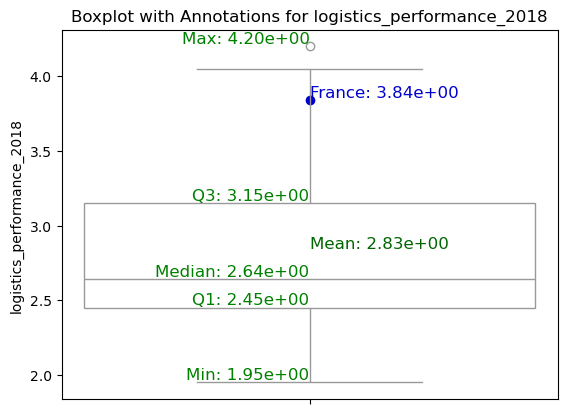



 Highest 10


,country,logistics_performance_2018
213,Germany,4.20
192,Sweden,4.05
211,Belgium,4.04
210,Austria,4.03
127,Japan,4.03
217,Netherlands (Kingdom of the),4.02
137,Singapore,4.00
193,United Kingdom of Great Britain and Northern I...,3.99
179,Denmark,3.99
182,Finland,3.97




 Lowest 10


,country,logistics_performance_2018
141,Afghanistan,1.95
29,Angola,2.05
8,Burundi,2.06
54,Niger,2.07
58,Sierra Leone,2.08
74,Haiti,2.11
2,Libya,2.11
28,Zimbabwe,2.12
31,Central African Republic,2.15
36,Gabon,2.16




 Outliers:


,country,logistics_performance_2018
213,Germany,4.2


In [25]:
complete_desc(all_data_df, 'logistics_performance_2018')

### Political stability and absence of violence index

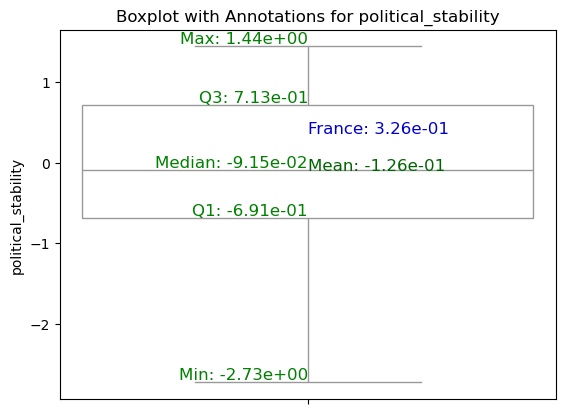



 Highest 10


,country,political_stability
137,Singapore,1.442505
223,New Zealand,1.394497
184,Iceland,1.372353
70,Dominica,1.334131
215,Luxembourg,1.194080
130,Brunei Darussalam,1.171810
231,Kiribati,1.137225
64,Barbados,1.118570
218,Switzerland,1.115376
243,Samoa,1.107971




 Lowest 10


,country,political_stability
23,Somalia,-2.727339
164,Syrian Arab Republic,-2.659650
167,Yemen,-2.580460
141,Afghanistan,-2.518676
155,Iraq,-2.384694
52,Mali,-2.332936
2,Libya,-2.308474
24,South Sudan,-2.287328
12,Ethiopia,-2.183831
31,Central African Republic,-2.126853




 Outliers:


,country,political_stability


In [26]:
complete_desc(all_data_df, 'political_stability')

### Corruption perception index

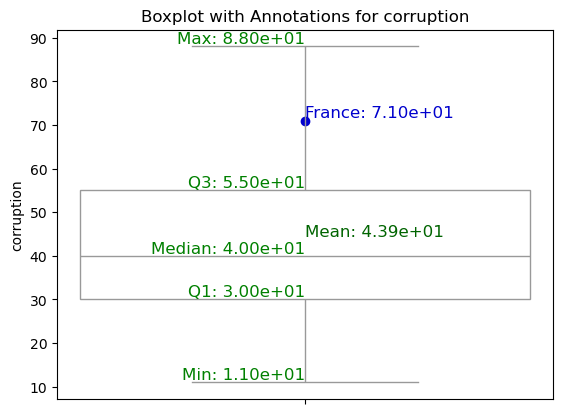



 Highest 10


,country,corruption
223,New Zealand,88.0
182,Finland,88.0
179,Denmark,88.0
190,Norway,85.0
137,Singapore,85.0
192,Sweden,85.0
218,Switzerland,84.0
217,Netherlands (Kingdom of the),82.0
215,Luxembourg,81.0
213,Germany,80.0




 Lowest 10


,country,corruption
24,South Sudan,11.0
23,Somalia,13.0
164,Syrian Arab Republic,13.0
111,Venezuela (Bolivarian Republic of),14.0
141,Afghanistan,16.0
167,Yemen,16.0
2,Libya,17.0
35,Equatorial Guinea,17.0
121,Turkmenistan,19.0
34,Democratic Republic of the Congo,19.0




 Outliers:


,country,corruption


In [27]:
complete_desc(all_data_df, 'corruption')

### Population

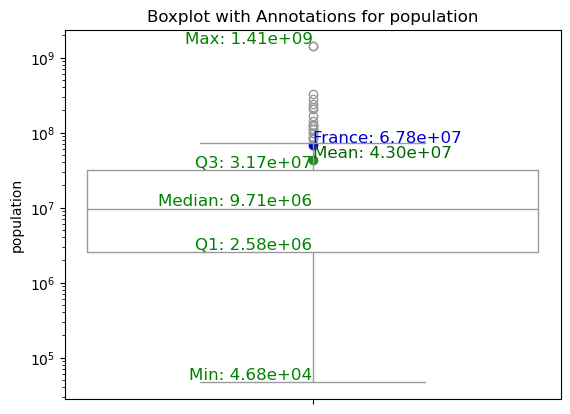



 Highest 10


,country,population
144,India,1.414204e+09
123,China,1.412360e+09
116,United States of America,3.320490e+08
132,Indonesia,2.767581e+08
148,Pakistan,2.394778e+08
55,Nigeria,2.185293e+08
99,Brazil,2.095503e+08
142,Bangladesh,1.676589e+08
175,Russian Federation,1.447468e+08
93,Mexico,1.276481e+08




 Lowest 10


,country,population
80,Saint Kitts and Nevis,46763.0
70,Dominica,67202.0
61,Antigua and Barbuda,92349.0
22,Seychelles,99258.0
83,Saint Vincent and the Grenadines,102841.0
245,Tonga,105490.0
72,Grenada,116688.0
231,Kiribati,128377.0
81,Saint Lucia,178522.0
243,Samoa,213779.0




 Outliers:


,country,population
144,India,1.414204e+09
123,China,1.412360e+09
116,United States of America,3.320490e+08
132,Indonesia,2.767581e+08
148,Pakistan,2.394778e+08
55,Nigeria,2.185293e+08
99,Brazil,2.095503e+08
142,Bangladesh,1.676589e+08
175,Russian Federation,1.447468e+08
93,Mexico,1.276481e+08


In [28]:
complete_desc(all_data_df, 'population', True)

complete_desc(all_data_df, 'population', True)

### Chicken consumption

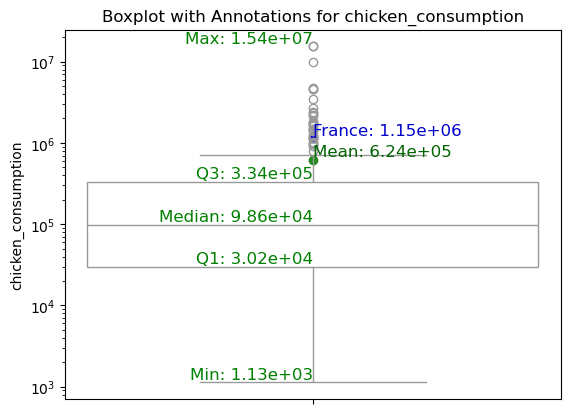



 Highest 10


,country,chicken_consumption
123,China,15438313.95
116,United States of America,15432263.59
99,Brazil,9847949.72
93,Mexico,4697314.09
144,India,4638029.80
175,Russian Federation,4552335.54
132,Indonesia,3455341.46
127,Japan,2728069.66
1,Egypt,2425360.74
42,South Africa,2350000.00




 Lowest 10


,country,chicken_consumption
231,Kiribati,1132.54
40,Lesotho,2196.09
80,Saint Kitts and Nevis,3289.61
37,Sao Tome and Principe,3493.17
70,Dominica,3571.46
143,Bhutan,3845.61
10,Djibouti,4378.87
22,Seychelles,4380.06
228,Solomon Islands,5035.66
229,Vanuatu,5438.27




 Outliers:


,country,chicken_consumption
123,China,15438313.95
116,United States of America,15432263.59
99,Brazil,9847949.72
93,Mexico,4697314.09
144,India,4638029.80
175,Russian Federation,4552335.54
132,Indonesia,3455341.46
127,Japan,2728069.66
1,Egypt,2425360.74
42,South Africa,2350000.00


In [29]:
complete_desc(all_data_df, 'chicken_consumption', True)

### Chicken consumption per capita

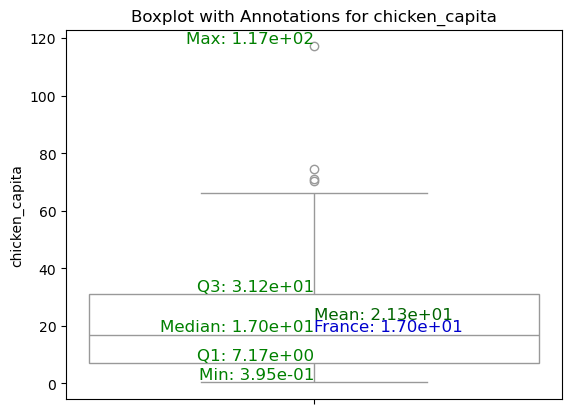



 Highest 10


,country,chicken_capita
245,Tonga,117.173
83,Saint Vincent and the Grenadines,74.609
243,Samoa,71.129
80,Saint Kitts and Nevis,70.346
63,Bahamas,66.156
61,Antigua and Barbuda,62.344
105,Guyana,60.024
130,Brunei Darussalam,59.447
161,Qatar,57.947
81,Saint Lucia,56.650




 Lowest 10


,country,chicken_capita
12,Ethiopia,0.395
32,Chad,0.443
23,Somalia,0.630
8,Burundi,0.639
34,Democratic Republic of the Congo,0.842
54,Niger,0.900
131,Cambodia,0.922
40,Lesotho,0.971
21,Rwanda,1.006
142,Bangladesh,1.287




 Outliers:


,country,chicken_capita
245,Tonga,117.173
83,Saint Vincent and the Grenadines,74.609
243,Samoa,71.129
80,Saint Kitts and Nevis,70.346


In [30]:
complete_desc(all_data_df, 'chicken_capita')

### Import quantity

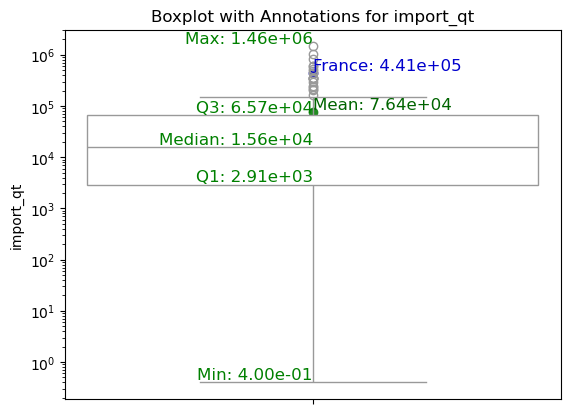



 Highest 10


,country,import_qt
123,China,1462452.93
93,Mexico,1029674.12
166,United Arab Emirates,835237.18
162,Saudi Arabia,597975.48
127,Japan,595830.28
217,Netherlands (Kingdom of the),530277.37
213,Germany,475448.52
212,France,440762.28
136,Philippines,359910.33
48,Ghana,357456.49




 Lowest 10


,country,import_qt
0,Algeria,0.4000
223,New Zealand,1.6700
105,Guyana,4.5800
142,Bangladesh,7.3800
102,Ecuador,11.0341
132,Indonesia,14.0700
88,Belize,16.8900
156,Israel,20.9785
57,Senegal,21.8800
149,Sri Lanka,22.0900




 Outliers:


,country,import_qt
123,China,1462452.93
93,Mexico,1029674.12
166,United Arab Emirates,835237.18
162,Saudi Arabia,597975.48
127,Japan,595830.28
217,Netherlands (Kingdom of the),530277.37
213,Germany,475448.52
212,France,440762.28
136,Philippines,359910.33
48,Ghana,357456.49


In [31]:
complete_desc(all_data_df, 'import_qt', True)

### Import value

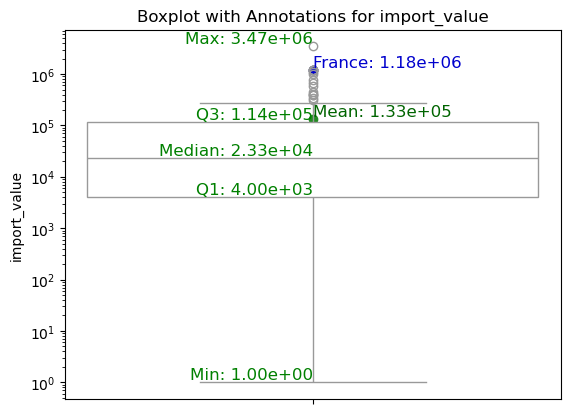



 Highest 10


,country,import_value
123,China,3468044.0
213,Germany,1224784.0
127,Japan,1200262.0
212,France,1182011.0
193,United Kingdom of Great Britain and Northern I...,1179164.0
162,Saudi Arabia,1176778.0
93,Mexico,1097957.0
217,Netherlands (Kingdom of the),986932.0
166,United Arab Emirates,751827.0
124,China Hong Kong Special Administrative Region,659143.0




 Lowest 10


,country,import_value
0,Algeria,1.00
223,New Zealand,7.00
57,Senegal,17.00
142,Bangladesh,20.00
105,Guyana,22.00
132,Indonesia,43.00
88,Belize,45.00
147,Nepal,49.06
102,Ecuador,51.83
149,Sri Lanka,53.00




 Outliers:


,country,import_value
123,China,3468044.0
213,Germany,1224784.0
127,Japan,1200262.0
212,France,1182011.0
193,United Kingdom of Great Britain and Northern I...,1179164.0
162,Saudi Arabia,1176778.0
93,Mexico,1097957.0
217,Netherlands (Kingdom of the),986932.0
166,United Arab Emirates,751827.0
124,China Hong Kong Special Administrative Region,659143.0


In [32]:
complete_desc(all_data_df, 'import_value', True)

### Import price

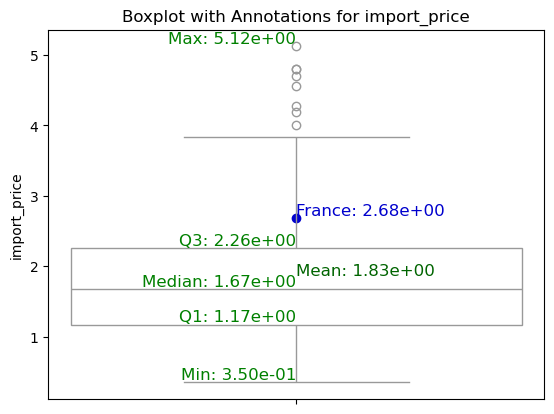



 Highest 10


,country,import_price
215,Luxembourg,5.12
105,Guyana,4.80
116,United States of America,4.80
102,Ecuador,4.70
218,Switzerland,4.55
184,Iceland,4.27
223,New Zealand,4.19
40,Lesotho,4.00
64,Barbados,3.84
1,Egypt,3.70




 Lowest 10


,country,import_price
26,United Republic of Tanzania,0.35
47,Gambia,0.35
34,Democratic Republic of the Congo,0.43
177,Ukraine,0.46
106,Paraguay,0.56
5,Tunisia,0.60
148,Pakistan,0.64
3,Morocco,0.65
51,Liberia,0.70
97,Bolivia (Plurinational State of),0.72




 Outliers:


,country,import_price
215,Luxembourg,5.12
105,Guyana,4.80
116,United States of America,4.80
102,Ecuador,4.70
218,Switzerland,4.55
184,Iceland,4.27
223,New Zealand,4.19
40,Lesotho,4.00


In [33]:
complete_desc(all_data_df, 'import_price')

## 5_Save table for PCA

We will perform the PCA analysis from another notebook.